Just-in-time compilation (JIT)
====

For programmer productivity, it often makes sense to code the majority of your application in a high-level language such as Python and only optimize code bottleneck identified by profiling. One way to speed up these bottleneck is to compile the code to machine executables, often via an intermediate C or C-like stage. There are two common approaches to compiling Python code - using a Just-In-Time (JIT) compiler and using Cython for Ahead of Time (AOT) compilation.

This notebook mostly illustrates the JIT approach.

**Utility function for timing functions**

In [1]:
import time
from numpy.testing import assert_almost_equal

In [2]:
def timer(f, *args, **kwargs):
    start = time.clock()
    ans = f(*args, **kwargs)
    return ans, time.clock() - start

In [3]:
def report(fs, *args, **kwargs):
    ans, t = timer(fs[0], *args, **kwargs)
    print('%s: %.1f' % (fs[0].__name__, 1.0))  
    for f in fs[1:]:
        ans_, t_ = timer(f, *args, **kwargs)
        print('%s: %.1f' % (f.__name__, t/t_))

Using `numexpr`
----

One of the simplest approaches is to use [`numexpr`](https://github.com/pydata/numexpr) which takes a `numpy` expression and compiles a more efficient version of the `numpy` expression written as a string. If there is a simple expression that is taking too long, this is a good choice due to its simplicity. However, it is quite limited.

In [4]:
a = np.random.random(int(1e6))
b = np.random.random(int(1e6))
c = np.random.random(int(1e6))

In [5]:
%timeit -r3 -n3 b**2 - 4*a*c

3 loops, best of 3: 31.6 ms per loop


In [6]:
import numexpr as ne

In [7]:
%timeit -r3 -n3 ne.evaluate('b**2 - 4*a*c')

3 loops, best of 3: 7.37 ms per loop


Using `numba`
----

When it works, the JIT `numba` can speed up Python code tremendously with minimal effort. 

[Documentation for `numba`](http://numba.pydata.org/numba-doc/0.12.2/index.html)

### Example 1

#### Plain Python version

In [8]:
def matrix_multiply(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [9]:
A = np.random.random((30, 50))
B = np.random.random((50, 40))

#### Numba jit version

In [10]:
import numba
from numba import jit

In [11]:
@jit
def matrix_multiply_numba(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [12]:
%timeit matrix_multiply(A, B)
%timeit matrix_multiply_numba(A, B)

10 loops, best of 3: 55.6 ms per loop
The slowest run took 2960.28 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 84.3 µs per loop


#### Numpy verssion

In [13]:
def matrix_multiply_numpy(A, B):
    return A.dot(B)

#### Check that outputs are the same

In [14]:
assert_almost_equal(matrix_multiply(A, B), matrix_multiply_numba(A, B))
assert_almost_equal(matrix_multiply(A, B), matrix_multiply_numpy(A, B))

In [15]:
%timeit -r3 -n3 matrix_multiply_numba(A, B)

3 loops, best of 3: 85.7 µs per loop


In [16]:
report([matrix_multiply, matrix_multiply_numba, matrix_multiply_numpy], A, B)

matrix_multiply: 1.0
matrix_multiply_numba: 48.8
matrix_multiply_numpy: 12.8


### Pre-compilation by giving specific signature 

In [17]:
@jit('double[:,:](double[:,:], double[:,:])')
def matrix_multiply_numba_1(A, B):
    m, n = A.shape
    n, p = B.shape
    C = np.zeros((m, p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] += A[i,k] * B[k, j]
    return C

In [18]:
%timeit matrix_multiply_numba(A, B)
%timeit matrix_multiply_numba_1(A, B)

10000 loops, best of 3: 84.7 µs per loop
10000 loops, best of 3: 84.4 µs per loop


### Example 2: Using nopython

#### Vectorized Python version

In [19]:
def mc_pi(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [20]:
n = int(1e6)

In [21]:
%timeit mc_pi(n)

10 loops, best of 3: 92.4 ms per loop


#### Numba on vectorized version

In [22]:
@jit
def mc_pi_numba(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [23]:
%timeit mc_pi_numba(n)

1 loops, best of 3: 93.9 ms per loop


#### Using nopython

In [24]:
@jit(nopython=True)
def mc_pi_numba_njit(n):
    x = np.random.uniform(-1, 1, (n,2))
    return 4*np.sum((x**2).sum(1) < 1)/n

In [25]:
from numba.errors import TypingError

In [26]:
try:
    mc_pi_numba_njit(n)
except TypingError:
    print("Unable to convert to pure C code.")

Unable to convert to pure C code.


#### Numba on unrolled version

In [27]:
@jit(nopython=True)
def mc_pi_numba_unrolled(n):
    s = 0
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if (x*x + y*y) < 1:
            s += 1
    return 4*s/n

In [28]:
%timeit mc_pi_numba_unrolled(n)

The slowest run took 4.32 times longer than the fastest. This could mean that an intermediate result is being cached 
10 loops, best of 3: 34.3 ms per loop


### Usig cache=True

This stores the compiled function in a file and avoids re-compilation on re-running a Python program.

In [29]:
@jit(nopython=True, cache=True)
def mc_pi_numba_unrolled_cache(n):
    s = 0
    for i in range(n):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        if (x*x + y*y) < 1:
            s += 1
    return 4*s/n

In [30]:
%timeit mc_pi_numba_unrolled_cache(n)

10 loops, best of 3: 34.3 ms per loop


Using numba vectorize and guvectoize
----

Sometimes it is convenient to use `numba` to convert functions to vectorized functions for use in `numpy`. See [documentation](http://numba.pydata.org/numba-doc/dev/user/vectorize.html) for details.

In [31]:
from numba import int32, int64, float32, float64

### Using `vectorize`

In [32]:
@numba.vectorize()
def f(x, y):
    return np.sqrt(x**2 + y**2)

In [33]:
xs = np.random.random(10)
ys = np.random.random(10)

In [34]:
np.array([np.sqrt(x**2 + y**2) for (x, y) in zip(xs, ys)])

array([ 0.83586973,  0.58145545,  0.90252105,  0.51664284,  0.10366498,
        0.77002446,  0.40796683,  0.71331601,  0.10956508,  0.43849604])

In [35]:
f(xs, ys)

array([ 0.83586973,  0.58145545,  0.90252105,  0.51664284,  0.10366498,
        0.77002446,  0.40796683,  0.71331601,  0.10956508,  0.43849604])

### Adding function signatures

In [36]:
@numba.vectorize([float64(float64, float64),
                  float32(float32, float32),
                  float64(int64, int64),
                  float32(int32, int32)])
def f_sig(x, y):
    return np.sqrt(x**2 + y**2)

In [37]:
f_sig(xs, ys)

array([ 0.83586973,  0.58145545,  0.90252105,  0.51664284,  0.10366498,
        0.77002446,  0.40796683,  0.71331601,  0.10956508,  0.43849604])

### Using `guvectorize` 

**Create our own version of inner1d**

In [38]:
@numba.guvectorize([(float64[:], float64[:], float64[:])], '(n),(n)->()')
def nb_inner1d(u, v, res):
    res[0] = 0
    for i in range(len(u)):
        res[0] += u[i]*v[i]

In [39]:
xs = np.random.random((3,4))

In [40]:
nb_inner1d(xs, xs)

array([ 1.19460598,  0.57993387,  1.86313815])

**Check**

In [41]:
from numpy.core.umath_tests import inner1d

In [42]:
inner1d(xs,xs)

array([ 1.19460598,  0.57993387,  1.86313815])

In [43]:
%timeit -r3 -n3 nb_inner1d(xs, xs)

3 loops, best of 3: 3.5 µs per loop


In [44]:
%timeit -r3 -n3 inner1d(xs, xs)

3 loops, best of 3: 3.57 µs per loop


**Create our own version of matrix_multiply**

In [45]:
@numba.guvectorize([(int64[:,:], int64[:,:], int64[:,:])], 
                    '(m,n),(n,p)->(m,p)')
def nb_matrix_multiply(u, v, res):
    m, n = u.shape
    n, p = v.shape
    for i in range(m):
        for j in range(p):
            res[i,j] = 0
            for k in range(n):
                res[i,j] += u[i,k] * v[k,j]

In [46]:
xs = np.random.randint(0, 10, (5, 2, 3))
ys = np.random.randint(0, 10, (5, 3, 2))

In [47]:
nb_matrix_multiply(xs, ys)

array([[[117,  89],
        [ 39,  72]],

       [[116,  47],
        [ 35,   8]],

       [[ 56,  93],
        [ 54,  56]],

       [[ 86,  42],
        [ 38,  57]],

       [[ 67,  73],
        [127, 163]]])

**Check**

In [48]:
from numpy.core.umath_tests import matrix_multiply

In [49]:
matrix_multiply(xs, ys)

array([[[117,  89],
        [ 39,  72]],

       [[116,  47],
        [ 35,   8]],

       [[ 56,  93],
        [ 54,  56]],

       [[ 86,  42],
        [ 38,  57]],

       [[ 67,  73],
        [127, 163]]])

In [50]:
%timeit -r3 -n3 nb_matrix_multiply(xs, ys)

3 loops, best of 3: 4.2 µs per loop


In [51]:
%timeit -r3 -n3 matrix_multiply(xs, ys)

3 loops, best of 3: 4.2 µs per loop


Parallelization with vectorize and guvectorize
----

In [52]:
@numba.vectorize([float64(float64, float64),
                  float32(float32, float32),
                  float64(int64, int64),
                  float32(int32, int32)],
                 target='parallel')
def f_parallel(x, y):
    return np.sqrt(x**2 + y**2)

In [53]:
xs = np.random.random(int(1e8))
ys = np.random.random(int(1e8))

In [54]:
%timeit f(xs, ys)

1 loops, best of 3: 1.42 s per loop


In [55]:
%timeit f_parallel(xs, ys)

1 loops, best of 3: 608 ms per loop


### Mandelbrot example wiht `numba`

**Pure Python**

In [56]:
# color function for point at (x, y)
def mandel(x, y, max_iters):
    c = complex(x, y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if z.real*z.real + z.imag*z.imag >= 4:
            return i
    return max_iters

In [57]:
def create_fractal(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x]  = color    

Mandelbrot created on CPU in 30.594740 s


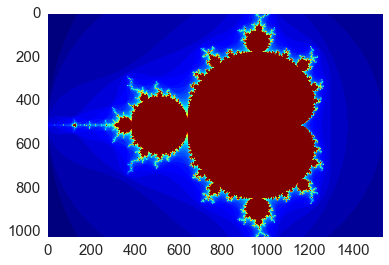

In [58]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created on CPU in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass

**Numba**

In [59]:
from numba import uint32, float32

**The jit decorator can also be called as a regular function**

In [60]:
mandel_numba = jit(uint32(float32, float32, uint32))(mandel)

In [61]:
@jit
def create_fractal_numba(xmin, xmax, ymin, ymax, image, iters):
    height, width = image.shape
    
    pixel_size_x = (xmax - xmin)/width
    pixel_size_y = (ymax - ymin)/height
        
    for x in range(width):
        real = xmin + x*pixel_size_x
        for y in range(height):
            imag = ymin + y*pixel_size_y
            color = mandel_numba(real, imag, iters)
            image[y, x]  = color  

Mandelbrot created wiht Numba in 0.498742 s


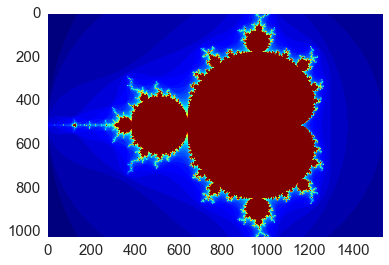

In [62]:
gimage = np.zeros((1024, 1536), dtype=np.uint8)
xmin, xmax, ymin, ymax = np.array([-2.0, 1.0, -1.0, 1.0]).astype('float32')
iters = 50

start = time.clock()
create_fractal_numba(xmin, xmax, ymin, ymax, gimage, iters)
dt = time.clock() - start

print("Mandelbrot created wiht Numba in %f s" % dt)
plt.grid(False)
plt.imshow(gimage, cmap='jet')
pass